In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

# Load Original Image

In [2]:
image = cv2.imread('images/cup-0011-gt.png') # Read as RGB image
# image = cv2.imread('images/step_500_10_pred_masked.png')
# image = cv2.imread('images/step_500_10_pred_nomask.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
image_height, image_width = image.shape[0], image.shape[1]
print(image_height)
print(image_width)

1080
1920


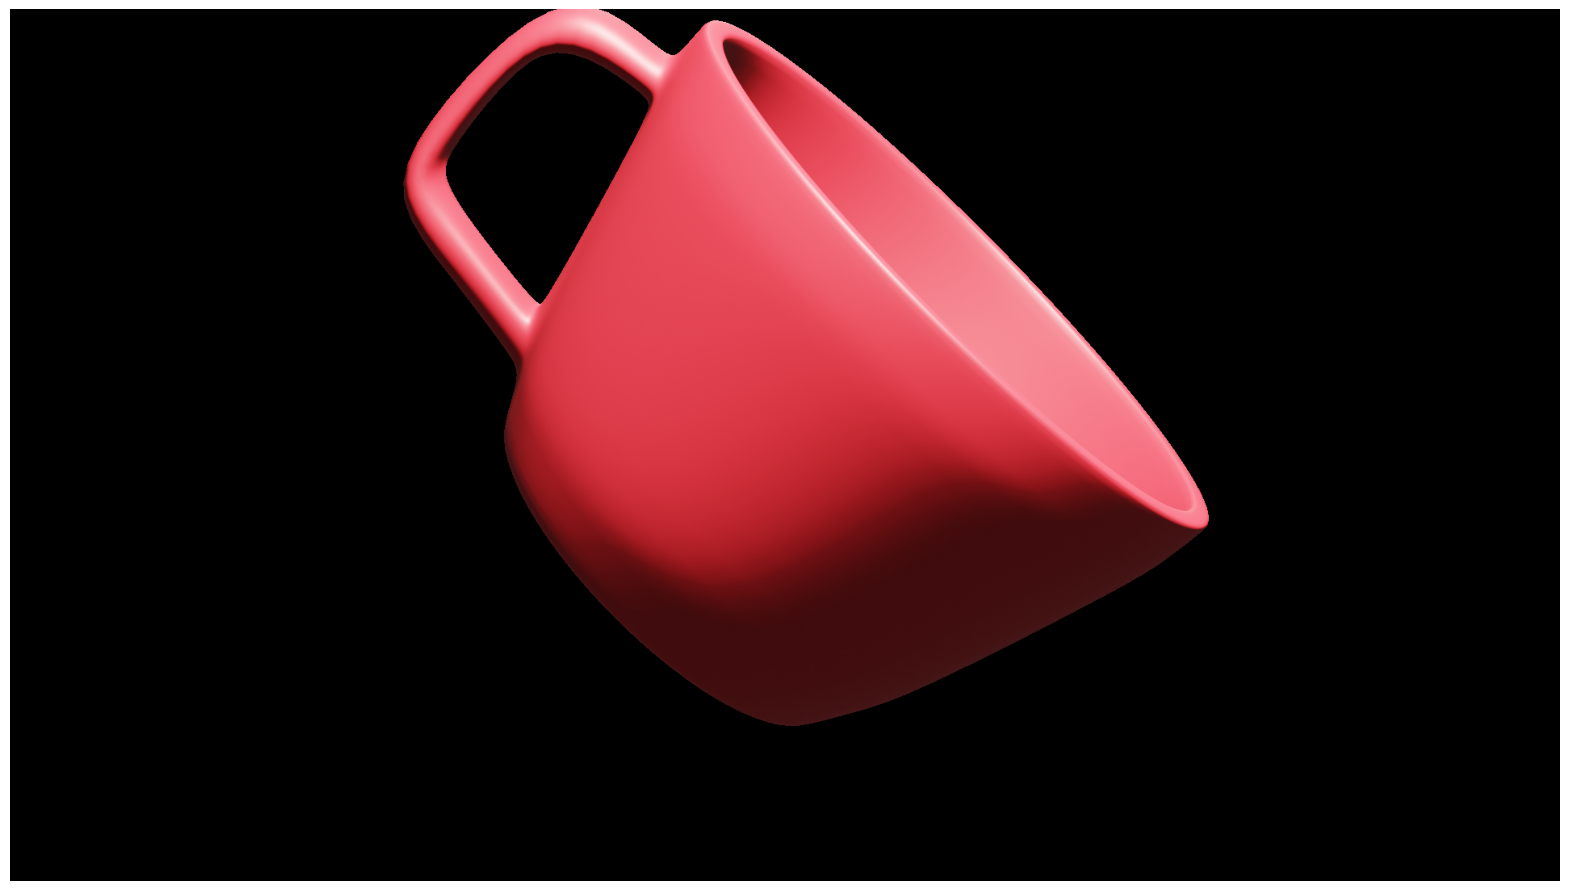

In [4]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

# Load SAM Model

In [5]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/home/kz/Desktop/Research/SAM/model/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

# sam = build_sam_vit_h(checkpoint="sam_vit_h_4b8939.pth")
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint) 
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=8, # Number of points to be sampled along one side of the image. Total number of points is this squared.
    min_mask_region_area=100,  # Requires open-cv to run post-processing; filter small disconnected regions and holes in masks the have smaller region than this value.
)

# Get Prompt Points

In [6]:
all_points = mask_generator.point_grids[0]
print(all_points.shape)

(64, 2)


In [7]:
cropped_im_size = image.shape[:2]
points_scale = np.array(cropped_im_size)[None, ::-1]
print(points_scale)

[[1920 1080]]


In [8]:
points_for_image = all_points * points_scale
print(points_for_image)

[[ 120.    67.5]
 [ 360.    67.5]
 [ 600.    67.5]
 [ 840.    67.5]
 [1080.    67.5]
 [1320.    67.5]
 [1560.    67.5]
 [1800.    67.5]
 [ 120.   202.5]
 [ 360.   202.5]
 [ 600.   202.5]
 [ 840.   202.5]
 [1080.   202.5]
 [1320.   202.5]
 [1560.   202.5]
 [1800.   202.5]
 [ 120.   337.5]
 [ 360.   337.5]
 [ 600.   337.5]
 [ 840.   337.5]
 [1080.   337.5]
 [1320.   337.5]
 [1560.   337.5]
 [1800.   337.5]
 [ 120.   472.5]
 [ 360.   472.5]
 [ 600.   472.5]
 [ 840.   472.5]
 [1080.   472.5]
 [1320.   472.5]
 [1560.   472.5]
 [1800.   472.5]
 [ 120.   607.5]
 [ 360.   607.5]
 [ 600.   607.5]
 [ 840.   607.5]
 [1080.   607.5]
 [1320.   607.5]
 [1560.   607.5]
 [1800.   607.5]
 [ 120.   742.5]
 [ 360.   742.5]
 [ 600.   742.5]
 [ 840.   742.5]
 [1080.   742.5]
 [1320.   742.5]
 [1560.   742.5]
 [1800.   742.5]
 [ 120.   877.5]
 [ 360.   877.5]
 [ 600.   877.5]
 [ 840.   877.5]
 [1080.   877.5]
 [1320.   877.5]
 [1560.   877.5]
 [1800.   877.5]
 [ 120.  1012.5]
 [ 360.  1012.5]
 [ 600.  1012.

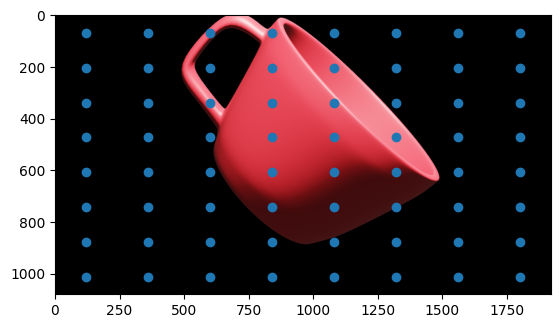

In [9]:
plt.scatter(points_for_image[:, 0], points_for_image[:, 1], marker="o")
plt.imshow(image)
plt.show()

In [10]:
im_size = points_for_image.shape[:2]
print(im_size)

(64, 2)


# Visualize Prompt Embeddings

In [11]:
def batch_iterator(batch_size: int, *args):
    # print("args[0] = ", args[0])
    n_batches = len(args[0]) // batch_size + int((len(args[0]) % batch_size) != 0) # Number of total batches
    # print("n_batches = ", n_batches)
    for b in range(n_batches):
        yield [arg[b * batch_size : (b + 1) * batch_size] for arg in args]

In [12]:
for (curr_points,) in batch_iterator(64, points_for_image):
    print("points = ", curr_points.shape)

points =  (64, 2)


In [13]:
transformed_points = mask_generator.predictor.transform.apply_coords(points_for_image, im_size)
in_points = torch.as_tensor(transformed_points, device=mask_generator.predictor.device) # batch_size x 2
in_labels = torch.ones(in_points.shape[0], dtype=torch.int, device=in_points.device) # batch_size x 1

print(in_points.shape)
print(in_labels.shape)

torch.Size([64, 2])
torch.Size([64])


In [14]:
point_coords = in_points[:, None, :]
point_labels = in_labels[:, None]
print(point_coords.shape)
print(point_labels.shape)

points = (point_coords, point_labels)

torch.Size([64, 1, 2])
torch.Size([64, 1])


In [15]:
sparse_embeddings, dense_embeddigns = mask_generator.predictor.model.prompt_encoder(
            points=points,
            boxes=None,
            masks=None,
        )

In [16]:
print(sparse_embeddings.shape)

torch.Size([64, 2, 256])


In [17]:
dim1 = sparse_embeddings[:, 0, :]
print(dim1.shape)

torch.Size([64, 256])


In [18]:
print(dim1)

tensor([[-0.7066,  0.2876, -0.1345,  ..., -0.9789, -0.0518,  0.2646],
        [ 0.7592,  0.4314, -0.4986,  ..., -0.8716, -0.9512, -0.6947],
        [-1.0930,  0.5605,  0.3096,  ..., -0.6893, -0.5231, -0.9141],
        ...,
        [-0.8758,  0.8396, -1.1662,  ...,  0.8735, -0.0069,  0.6874],
        [ 0.7970,  0.7799,  0.6757,  ...,  0.9748,  0.9587,  1.0225],
        [-0.9789,  0.6961, -0.9428,  ...,  0.9915,  0.6345,  0.3673]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [19]:
dim2 = sparse_embeddings[:, 1, :]
print(dim2.shape)

torch.Size([64, 256])


In [20]:
print(dim2)

tensor([[-0.1437, -0.0746, -0.0234,  ...,  0.0210, -0.0815,  0.0966],
        [-0.1437, -0.0746, -0.0234,  ...,  0.0210, -0.0815,  0.0966],
        [-0.1437, -0.0746, -0.0234,  ...,  0.0210, -0.0815,  0.0966],
        ...,
        [-0.1437, -0.0746, -0.0234,  ...,  0.0210, -0.0815,  0.0966],
        [-0.1437, -0.0746, -0.0234,  ...,  0.0210, -0.0815,  0.0966],
        [-0.1437, -0.0746, -0.0234,  ...,  0.0210, -0.0815,  0.0966]],
       device='cuda:0', grad_fn=<SliceBackward0>)


In [21]:
img1 = dim1.cpu().detach().numpy()
print(img1.shape)

img2 = dim2.cpu().detach().numpy()
print(img2.shape)

(64, 256)
(64, 256)


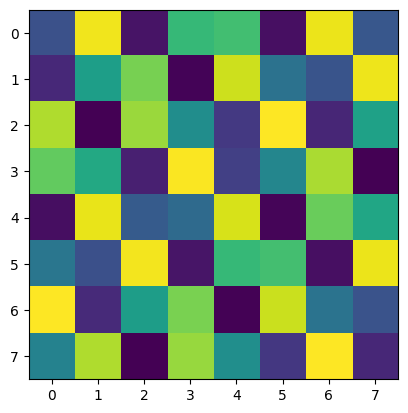

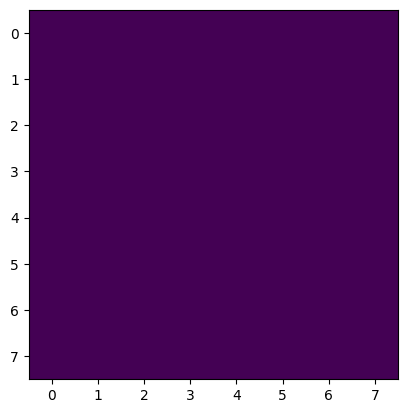

In [22]:
img1 = img1.reshape(8, 8, 256)
plt.imshow(img1[:, :, 0], cmap='viridis')
plt.show()

img2 = img2.reshape(8, 8, 256)
plt.imshow(img2[:, :, 0], cmap='viridis')
plt.show()

In [23]:
print(dense_embeddigns.shape)

torch.Size([64, 256, 64, 64])


In [24]:
image_embeddings = mask_generator.predictor.features

In [25]:
print(image_embeddings.shape)

AttributeError: 'NoneType' object has no attribute 'shape'